# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we are going to study the relationship between the price and number of the housing rental with the venues contained in the neighborhoods. We will work with the city of Valencia, Spain.

We will seek to answer the following questions:
* Which neighborhood offers the best price / number ratio for venues?
* Is there a correlation between price and the venues?
* Is there a correlation between the number of apartments per neighborhood and the venues?
* In which neighborhood would it be advisable to rent an apartment?

## Data <a name="data"></a>

We will need the following information to carry out the project:
* Number of rental properties per neighborhood.
* Median value of the rental price per neighborhood.
* Type and amount of venues by neighborhood.
* Information on the spatial limits of each neighborhood.

The first two points we will look for through airbnb data collections.
The third point through Foursquare.
And the last point thanks to the portal of the Valencia City Council.
http://gobiernoabierto.valencia.es/en/


### load/install librarys

In [1]:
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import requests
import json

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
!pip install pyproj
from pyproj import Transformer

!pip install geopandas
import geopandas as gpd  # need to build a json with WGS format, folium use that format in geojson
!pip install folium
import folium
!pip install shapely
from shapely.geometry import Polygon

     |████████████████████████████████| 10.9MB 7.3MB/s eta 0:00:01
     |████████████████████████████████| 931kB 8.0MB/s eta 0:00:01
     |████████████████████████████████| 1.8MB 38.9MB/s eta 0:00:01
     |████████████████████████████████| 14.7MB 36.5MB/s eta 0:00:01     |███████████████████████████▏    | 12.5MB 36.5MB/s eta 0:00:01
     |████████████████████████████████| 102kB 8.3MB/s ta 0:00:011


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### data collection
##### Position of each neighborhood

In [3]:
!wget -q -O 'valencia_data.json' http://mapas.valencia.es/lanzadera/opendata/Barrios/JSON
print('Data downloaded!')

Data downloaded!


In [4]:
with open('valencia_data.json') as json_data:
    valencia_data = json.load(json_data)

In [5]:
neighborhoods_data = valencia_data['features']
# define the dataframe columns
column_names = ['coddistbar', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
transformer = Transformer.from_crs("epsg:25830", "epsg:4326")  # convert utm30 to wgs84

for data in neighborhoods_data:
    coddistbar = data['properties']['coddistbar'] 
    neighborhood_name = data['properties']['nombre']
        
    neighborhood_latlon = np.array(data['geometry']['coordinates'][0])
    neighborhood_latlon = Polygon(neighborhood_latlon).centroid.coords[0]
    neighborhood_lat, neighborhood_lon = transformer.transform(neighborhood_latlon[0], neighborhood_latlon[1])
    neighborhoods = neighborhoods.append({'coddistbar': coddistbar,
                                          'Neighborhood': neighborhood_name,
                                          #'x': neighborhood_latlon.mean(axis=0)[0],
                                          #'y': neighborhood_latlon.mean(axis=0)[1],
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [6]:
neighborhoods.style.format("{:.4f}")
pd.options.display.float_format = '{:.5f}'.format
neighborhoods.head()

,coddistbar,Neighborhood,Latitude,Longitude
0,171,BENIFARAIG,39.52564,-0.38462
1,161,BENICALAP,39.49301,-0.39100
2,152,TORREFIEL,39.49520,-0.37693
3,054,TORMOS,39.48930,-0.37939
4,055,SANT ANTONI,39.48871,-0.37323


##### Loading of rental data

In [7]:
df_airbnb = pd.read_csv('https://code.montera34.com/airbnb/valencia/-/raw/master/data/original/airbnb/190227/listings_summary_valencia_insideairbnb.csv', index_col=False)

In [8]:
df_airbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,4620,VALENCIA HISTORIC HOUSE 50M BEACH,7093832,Francisca,POBLATS MARITIMS,LA MALVA-ROSA,39.47553,-0.32461,Entire home/apt,150,2,76,2019-01-21,0.91000,1,305
1,45528,Valencia: El Saler Beach and Albufera Lake,202104,Lidia,POBLATS DEL SUD,EL SALER,39.35621,-0.32292,Entire home/apt,60,3,46,2018-12-08,0.65000,1,50
2,48154,beautiful apartment wifi,219476,Toni,LA SAIDIA,MORVEDRE,39.48575,-0.37428,Entire home/apt,45,3,71,2018-12-06,0.70000,3,345
3,55692,Delight in city center,120649,Pilar,CIUTAT VELLA,LA SEU,39.47681,-0.37523,Entire home/apt,100,1,1,2014-11-11,0.02000,1,146
4,95393,Modern and bright Duplex 3 Bedrooms Center Wi-Fi,508042,Carmen,CIUTAT VELLA,EL CARME,39.47787,-0.38142,Entire home/apt,134,1,88,2019-02-22,0.94000,6,167


We grouped the data by neighborhoods obtaining the average value of the price per neighborhood as well as the number of apartments for rent per neighborhood

In [9]:
df = df_airbnb.groupby('neighbourhood')['price'].mean().to_frame().reset_index().rename(columns={'neighbourhood': 'Neighborhood'})
df_std = df_airbnb.groupby('neighbourhood').std()[['price']].reset_index().rename(columns={'price':'price_std', 'neighbourhood': 'Neighborhood'})
df_count = df_airbnb.groupby('neighbourhood').count()[['price']].reset_index().rename(columns={'price':'number', 'neighbourhood': 'Neighborhood'})
df = df.merge(df_std, on=['Neighborhood']).fillna(0)
df = df.merge(df_count, on=['Neighborhood'])

We gather the data from the town hall together with the data from the rental of housing

In [10]:
df1 = df.merge(neighborhoods, on='Neighborhood')
df1 = df1.astype({'coddistbar':'int'})
df1.head(25)


,Neighborhood,price,price_std,number,coddistbar,Latitude,Longitude
0,AIORA,47.11230,41.10939,187,121,39.46573,-0.34336
1,ALBORS,53.35000,38.03692,60,122,39.46854,-0.35276
2,ARRANCAPINS,59.62745,43.37712,204,34,39.46410,-0.38427
3,BENICALAP,45.81250,38.45796,80,161,39.49301,-0.39100
4,BENIFERRI,52.66667,31.08590,3,182,39.49620,-0.40572
5,BENIMACLET,39.93913,35.14414,115,141,39.48460,-0.35940
6,BENIMAMET,51.56522,56.81457,46,181,39.50127,-0.42214
7,BETERO,44.97872,29.32834,47,114,39.47197,-0.33624
8,BORBOTO,60.00000,0.00000,1,177,39.51912,-0.39354
9,CABANYAL-CANYAMELAR,70.57904,52.96126,563,112,39.46879,-0.32922


When reviewing we realize that data is missing about a neighborhood. We just ignore it in the project.

In [11]:
df1.shape

(87, 7)

In [12]:
neighborhoods.shape

(88, 4)

In [13]:
set(df1.Neighborhood.to_list()).symmetric_difference(neighborhoods.Neighborhood)

{'BENIFARAIG'}

We represent a map with neighborhoods drawn.

In [14]:
data = gpd.read_file("valencia_data.json")
data.to_crs(epsg=4326).to_file("valencia_data_wgs.json", driver="GeoJSON")
m = folium.Map(location=[39.46, -.3], zoom_start=11)
folium.GeoJson(
    "valencia_data_wgs.json",
    name='geojson'
).add_to(m)

m

To the previous map we add the rental price, dark colors represent higher prices.

In [15]:
m = folium.Map(location=[39.46, -.3], zoom_start=11)
bins = list(df1['price'].quantile([0, 0.1, 0.6, 0.85, 1]))
folium.Choropleth(
    geo_data="valencia_data_wgs.json",
    name='choropleth',
    data=df1,
    columns=['Neighborhood', 'price'],
    key_on='feature.properties.nombre',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    bins=bins,
    legend_name='price of houses for rent'
).add_to(m)




m

We repeat the process but with the number of houses for rent.

In [16]:
m = folium.Map(location=[39.46, -.3], zoom_start=11)
folium.Choropleth(
    geo_data="valencia_data_wgs.json",
    name='choropleth',
    data=df1,
    columns=['Neighborhood', 'number'],
    key_on='feature.properties.nombre',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='number of houses for rent'
).add_to(m)

m

##### Venues data from Fousquare

I hide the information about my Foursquare account.

In [17]:
# The code was removed by Watson Studio for sharing.

We set the parameters and load a test neighborhood.

In [18]:
neighborhood_latitude = df1.loc[9, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df1.loc[9, 'Longitude'] # neighborhood longitude value
LIMIT = 100
radius = 250
VERSION = '20180604'

In [19]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude,
    neighborhood_longitude,
    radius,
    LIMIT)

In [20]:
results = requests.get(url).json()
#print('There are {} around Ecco restaurant.'.format(len(results['response']['groups'][0]['items'])))
results

{'meta': {'code': 200, 'requestId': '5eb6c7b70f5968001c31b085'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'El Cabanyal-El Canyamelar',
  'headerFullLocation': 'El Cabanyal-El Canyamelar, Valencia',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 13,
  'suggestedBounds': {'ne': {'lat': 39.47104016018421,
    'lng': -0.32631324241816945},
   'sw': {'lat': 39.46654015568421, 'lng': -0.33213159928394614}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e25e79545dd3b8cf8fdda4e',
       'name': 'Barri del Cabanyal',
       'location': {'lat': 39.46842962639599,
        'lng': -0.32990685256349694,
        'labeledLatLngs': [{'label': 'display',
          'lat': 3

In [21]:
def getNearbyVenues(names, latitudes, longitudes, _LIMIT, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        if radius is None:
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng,
                _LIMIT)
            
        else:  
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng,
                radius,
                _LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We load all the data with the function defined above.

In [22]:
valencia_venues = getNearbyVenues(names=df1['Neighborhood'],
                                   latitudes=df1['Latitude'],
                                   longitudes=df1['Longitude'],
                                  _LIMIT=LIMIT,
                                  radius=radius
                                  )


AIORA
ALBORS
ARRANCAPINS
BENICALAP
BENIFERRI
BENIMACLET
BENIMAMET
BETERO
BORBOTO
CABANYAL-CANYAMELAR
CAMI DE VERA
CAMI FONDO
CAMI REAL
CAMPANAR
CARPESA
CASTELLAR-L'OLIVERAL
CIUTAT DE LES ARTS I DE LES CIENCIES
CIUTAT FALLERA
CIUTAT JARDI
CIUTAT UNIVERSITARIA
EL BOTANIC
EL CALVARI
EL CARME
EL FORN D'ALCEDO
EL GRAU
EL MERCAT
EL PALMAR
EL PERELLONET
EL PILAR
EL PLA DEL REMEI
EL SALER
ELS ORRIOLS
EN CORTS
EXPOSICIO
FAITANAR
FAVARA
JAUME ROIG
L'AMISTAT
L'HORT DE SENABRE
L'ILLA PERDUDA
LA CARRASCA
LA CREU COBERTA
LA CREU DEL GRAU
LA FONTETA S.LLUIS
LA FONTSANTA
LA GRAN VIA
LA LLUM
LA MALVA-ROSA
LA PETXINA
LA PUNTA
LA RAIOSA
LA ROQUETA
LA SEU
LA TORRE
LA VEGA BAIXA
LA XEREA
LES CASES DE BARCENA
LES TENDETES
MAHUELLA-TAULADELLA
MALILLA
MARXALENES
MASSARROJOS
MESTALLA
MONT-OLIVET
MORVEDRE
NA ROVELLA
NATZARET
NOU MOLES
PATRAIX
PENYA-ROJA
PINEDO
POBLE NOU
RAFALELL-VISTABELLA
RUSSAFA
SAFRANAR
SANT ANTONI
SANT FRANCESC
SANT ISIDRE
SANT LLORENS
SANT MARCEL.LI
SANT PAU
SOTERNES
TORMOS
TORREFIEL
TRES 

In [23]:
print(valencia_venues.head())
print(valencia_venues.shape)

  Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0        AIORA               39.46573                -0.34336   
1        AIORA               39.46573                -0.34336   
2        AIORA               39.46573                -0.34336   
3       ALBORS               39.46854                -0.35276   
4       ALBORS               39.46854                -0.35276   

                                      Venue  Venue Latitude  Venue Longitude  \
0                               Casa Emilio        39.46457         -0.34578   
1  Centro Supera Piscina Municipal de Ayora        39.46550         -0.34408   
2                               Bar Octavio        39.46370         -0.34441   
3                                     McFIT        39.46691         -0.35119   
4                                 Mercadona        39.46776         -0.35166   

         Venue Category  
0        Sandwich Place  
1  Gym / Fitness Center  
2                  Café  
3  Gym / Fitness Center 

In [24]:
valencia_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,AIORA,39.46573,-0.34336,Casa Emilio,39.46457,-0.34578,Sandwich Place
1,AIORA,39.46573,-0.34336,Centro Supera Piscina Municipal de Ayora,39.46550,-0.34408,Gym / Fitness Center
2,AIORA,39.46573,-0.34336,Bar Octavio,39.46370,-0.34441,Café
3,ALBORS,39.46854,-0.35276,McFIT,39.46691,-0.35119,Gym / Fitness Center
4,ALBORS,39.46854,-0.35276,Mercadona,39.46776,-0.35166,Grocery Store


Tourists may choose housing based on the proximity of places of interest, even if these places are not in the same neighborhood. So I remove the radius constraint.

In [25]:
valencia_venues_no_radius = getNearbyVenues(df1['Neighborhood'],
                                   df1['Latitude'],
                                   df1['Longitude'],
                                   LIMIT,
                                   None)

AIORA
ALBORS
ARRANCAPINS
BENICALAP
BENIFERRI
BENIMACLET
BENIMAMET
BETERO
BORBOTO
CABANYAL-CANYAMELAR
CAMI DE VERA
CAMI FONDO
CAMI REAL
CAMPANAR
CARPESA
CASTELLAR-L'OLIVERAL
CIUTAT DE LES ARTS I DE LES CIENCIES
CIUTAT FALLERA
CIUTAT JARDI
CIUTAT UNIVERSITARIA
EL BOTANIC
EL CALVARI
EL CARME
EL FORN D'ALCEDO
EL GRAU
EL MERCAT
EL PALMAR
EL PERELLONET
EL PILAR
EL PLA DEL REMEI
EL SALER
ELS ORRIOLS
EN CORTS
EXPOSICIO
FAITANAR
FAVARA
JAUME ROIG
L'AMISTAT
L'HORT DE SENABRE
L'ILLA PERDUDA
LA CARRASCA
LA CREU COBERTA
LA CREU DEL GRAU
LA FONTETA S.LLUIS
LA FONTSANTA
LA GRAN VIA
LA LLUM
LA MALVA-ROSA
LA PETXINA
LA PUNTA
LA RAIOSA
LA ROQUETA
LA SEU
LA TORRE
LA VEGA BAIXA
LA XEREA
LES CASES DE BARCENA
LES TENDETES
MAHUELLA-TAULADELLA
MALILLA
MARXALENES
MASSARROJOS
MESTALLA
MONT-OLIVET
MORVEDRE
NA ROVELLA
NATZARET
NOU MOLES
PATRAIX
PENYA-ROJA
PINEDO
POBLE NOU
RAFALELL-VISTABELLA
RUSSAFA
SAFRANAR
SANT ANTONI
SANT FRANCESC
SANT ISIDRE
SANT LLORENS
SANT MARCEL.LI
SANT PAU
SOTERNES
TORMOS
TORREFIEL
TRES 

In [26]:
print(valencia_venues_no_radius.shape)

(7988, 7)


## Methodology <a name="methodology"></a>

We have already loaded all the necessary data to carry out the project. Data from three sources:
* Valencia City Hall.
* Airbnb data collection.
* Data from Foursquare.   

Next, we will group the venues according to the neighborhood and we will gather all the data in the same table. We will explore the data looking for the correlations between the variables.   
Finally we will apply linear regression in order to obtain the r2 score to determine if the features have predictive capacity.
  
With the relationship already calculated we will decide which is the best neighborhood to put an apartment for rent.
In addition we will obtain the ratio between price and number of venues.

We obtain a table that contains the price and the number of places of interest by neighborhoods.

In [27]:
df_num_venues = valencia_venues['Neighborhood'].value_counts().to_frame()
df_num_venues.rename(columns={'Neighborhood':'count'}, inplace=True)
df_num_venues.reset_index(inplace=True)
df_num_venues.rename(columns={'index':'Neighborhood'}, inplace=True)
df_num_venues.head()

,Neighborhood,count
0,RUSSAFA,65
1,LA GRAN VIA,59
2,LA SEU,58
3,SANT FRANCESC,53
4,EL MERCAT,44


In [28]:
df_num_venues_and_price = df1.merge(df_num_venues, on='Neighborhood')
df_num_venues_and_price.head()

,Neighborhood,price,price_std,number,coddistbar,Latitude,Longitude,count
0,AIORA,47.11230,41.10939,187,121,39.46573,-0.34336,3
1,ALBORS,53.35000,38.03692,60,122,39.46854,-0.35276,3
2,ARRANCAPINS,59.62745,43.37712,204,34,39.46410,-0.38427,27
3,BENICALAP,45.81250,38.45796,80,161,39.49301,-0.39100,5
4,BENIFERRI,52.66667,31.08590,3,182,39.49620,-0.40572,3


At this time we can already calculate the ratio between the price and the number of homes. Understanding the best ratio as the highest number of venues per price unit, that is, the one with the lowest ratio.

In [29]:
df_num_venues_and_price = df_num_venues_and_price.set_index('Neighborhood')

In [30]:
df_num_venues_and_price['ratio'] = df_num_venues_and_price[['price','count']].apply(lambda x:x[0]/x[1], axis=1)
df_num_venues_and_price.sort_values(by='ratio', inplace=True)

df_num_venues_and_price.head()

,price,price_std,number,coddistbar,Latitude,Longitude,count,ratio
Neighborhood,,,,,,,,
RUSSAFA,64.60640,41.75456,531,21,39.46119,-0.37370,65,0.99394
LA GRAN VIA,65.25806,43.86901,62,23,39.46554,-0.36552,59,1.10607
BENIMACLET,39.93913,35.14414,115,141,39.48460,-0.35940,34,1.17468
CIUTAT JARDI,58.80597,42.10133,67,132,39.47198,-0.34504,44,1.33650
LA VEGA BAIXA,58.64000,40.43913,25,134,39.47631,-0.34997,43,1.36372


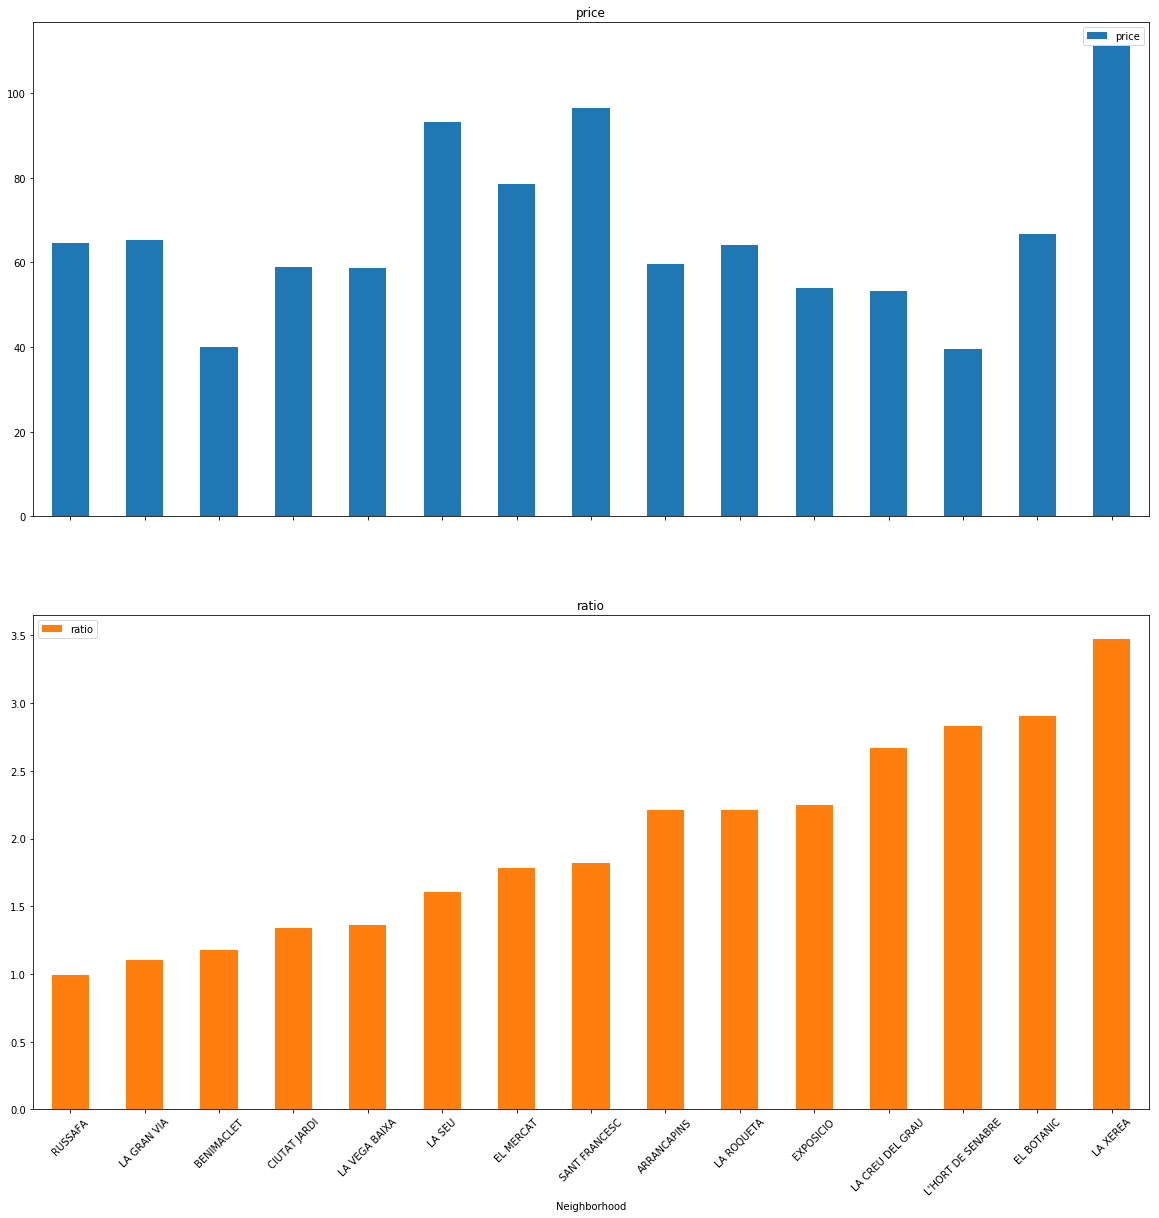

In [31]:
axes = df_num_venues_and_price[['price', 'ratio']].head(15).plot.bar(rot=45, subplots=True,figsize=(20,20))

axes[1].legend(loc=2) 

Now we return with the data of venues obtained without using the radius.
First, we dummify the categorical variable type of venue.

In [32]:
# one hot encoding
valencia_onehot = pd.get_dummies(valencia_venues_no_radius[['Venue Category']], prefix="", prefix_sep="")

fixed_columns = ['Neighborhood'] + list(set(valencia_onehot.columns.to_list()).difference(['Neighborhood']))
# add neighborhood column back to dataframe
valencia_onehot['Neighborhood'] = valencia_venues_no_radius['Neighborhood'] 

# move neighborhood column to the first column
#fixed_columns = [valencia_onehot.columns[-1]] + list(valencia_onehot.columns[:-1])

valencia_onehot = valencia_onehot[fixed_columns]

valencia_onehot.head()

,Neighborhood,Scenic Lookout,Tennis Stadium,Lounge,Bagel Shop,Bowling Alley,Sandwich Place,Soccer Field,Big Box Store,Moroccan Restaurant,Gas Station,Art Museum,Beer Bar,Pub,Cupcake Shop,Food Truck,Aquarium,Beach Bar,Post Office,Garden Center,Creperie,Exhibit,Gastropub,Athletics & Sports,Pool,Track Stadium,Middle Eastern Restaurant,Soccer Stadium,Garden,Strip Club,Salad Place,Event Space,French Restaurant,Department Store,Monument / Landmark,Gaming Cafe,Indie Movie Theater,Warehouse Store,Public Art,Modern European Restaurant,Stadium,Convention Center,Korean Restaurant,Falafel Restaurant,Music Venue,Bistro,Cuban Restaurant,Electronics Store,Opera House,Sporting Goods Shop,Ramen Restaurant,Modern Greek Restaurant,Dessert Shop,Theme Park,Seafood Restaurant,Argentinian Restaurant,Bed & Breakfast,Taco Place,Pedestrian Plaza,Brazilian Restaurant,Performing Arts Venue,Italian Restaurant,Gym / Fitness Center,Pizza Place,Multiplex,Museum,Furniture / Home Store,Coffee Shop,Juice Bar,Rest Area,Video Game Store,Pie Shop,Bar,Food & Drink Shop,Liquor Store,Park,Noodle House,Frozen Yogurt Shop,Zoo Exhibit,Movie Theater,Brewery,Gym,Market,Hostel,Steakhouse,Science Museum,Dive Bar,Gym Pool,Shopping Mall,Pharmacy,Nudist Beach,Thrift / Vintage Store,Soup Place,Café,Planetarium,Beach,Grocery Store,Harbor / Marina,Nightclub,Road,Shop & Service,Beer Garden,Diner,Mobile Phone Shop,Zoo,Record Shop,Paella Restaurant,General Entertainment,Bakery,Buffet,Construction & Landscaping,Greek Restaurant,Football Stadium,Latin American Restaurant,Speakeasy,Asian Restaurant,Pet Store,Hotel Bar,Surf Spot,Sushi Restaurant,Candy Store,Spa,Convenience Store,Deli / Bodega,Breakfast Spot,Farmers Market,Arts & Crafts Store,Beer Store,Train Station,Theme Restaurant,Shoe Store,Bike Rental / Bike Share,Basketball Stadium,Concert Hall,Comedy Club,Mediterranean Restaurant,Boutique,German Restaurant,Botanical Garden,Snack Place,Halal Restaurant,Music Store,BBQ Joint,Fast Food Restaurant,Spanish Restaurant,Tapas Restaurant,Vegetarian / Vegan Restaurant,Casino,Lake,Molecular Gastronomy Restaurant,Jazz Club,Campground,Golf Course,Ice Cream Shop,History Museum,Gourmet Shop,Hotel,Arepa Restaurant,Plaza,Light Rail Station,Dog Run,Outdoors & Recreation,Supermarket,Southern / Soul Food Restaurant,Comic Shop,Dance Studio,Other Great Outdoors,Playground,Art Gallery,Cocktail Bar,Miscellaneous Shop,Wine Bar,Racetrack,Bookstore,Burger Joint,Restaurant,Indian Restaurant,Camera Store,Sports Club,Mexican Restaurant,Cosmetics Shop,Gift Shop,Bridge,Cruise,Nature Preserve,Other Nightlife,Clothing Store,Irish Pub,Pastry Shop,Food,Theater,Toy / Game Store,Chinese Restaurant,Cheese Shop,Japanese Restaurant,Metro Station,Rock Club,Tea Room,American Restaurant,Sports Bar,Tennis Court,Historic Site,Church
0,AIORA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,AIORA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,AIORA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Then we group by neighborhood through the average value on the created variables.

In [33]:
valencia_onehot_aux = valencia_onehot.groupby('Neighborhood').mean().reset_index()
valencia_onehot_aux['number_venues'] = valencia_onehot.groupby('Neighborhood').count().reset_index().iloc[:,1]
valencia_onehot = valencia_onehot_aux
valencia_onehot.head()

,Neighborhood,Scenic Lookout,Tennis Stadium,Lounge,Bagel Shop,Bowling Alley,Sandwich Place,Soccer Field,Big Box Store,Moroccan Restaurant,Gas Station,Art Museum,Beer Bar,Pub,Cupcake Shop,Food Truck,Aquarium,Beach Bar,Post Office,Garden Center,Creperie,Exhibit,Gastropub,Athletics & Sports,Pool,Track Stadium,Middle Eastern Restaurant,Soccer Stadium,Garden,Strip Club,Salad Place,Event Space,French Restaurant,Department Store,Monument / Landmark,Gaming Cafe,Indie Movie Theater,Warehouse Store,Public Art,Modern European Restaurant,Stadium,Convention Center,Korean Restaurant,Falafel Restaurant,Music Venue,Bistro,Cuban Restaurant,Electronics Store,Opera House,Sporting Goods Shop,Ramen Restaurant,Modern Greek Restaurant,Dessert Shop,Theme Park,Seafood Restaurant,Argentinian Restaurant,Bed & Breakfast,Taco Place,Pedestrian Plaza,Brazilian Restaurant,Performing Arts Venue,Italian Restaurant,Gym / Fitness Center,Pizza Place,Multiplex,Museum,Furniture / Home Store,Coffee Shop,Juice Bar,Rest Area,Video Game Store,Pie Shop,Bar,Food & Drink Shop,Liquor Store,Park,Noodle House,Frozen Yogurt Shop,Zoo Exhibit,Movie Theater,Brewery,Gym,Market,Hostel,Steakhouse,Science Museum,Dive Bar,Gym Pool,Shopping Mall,Pharmacy,Nudist Beach,Thrift / Vintage Store,Soup Place,Café,Planetarium,Beach,Grocery Store,Harbor / Marina,Nightclub,Road,Shop & Service,Beer Garden,Diner,Mobile Phone Shop,Zoo,Record Shop,Paella Restaurant,General Entertainment,Bakery,Buffet,Construction & Landscaping,Greek Restaurant,Football Stadium,Latin American Restaurant,Speakeasy,Asian Restaurant,Pet Store,Hotel Bar,Surf Spot,Sushi Restaurant,Candy Store,Spa,Convenience Store,Deli / Bodega,Breakfast Spot,Farmers Market,Arts & Crafts Store,Beer Store,Train Station,Theme Restaurant,Shoe Store,Bike Rental / Bike Share,Basketball Stadium,Concert Hall,Comedy Club,Mediterranean Restaurant,Boutique,German Restaurant,Botanical Garden,Snack Place,Halal Restaurant,Music Store,BBQ Joint,Fast Food Restaurant,Spanish Restaurant,Tapas Restaurant,Vegetarian / Vegan Restaurant,Casino,Lake,Molecular Gastronomy Restaurant,Jazz Club,Campground,Golf Course,Ice Cream Shop,History Museum,Gourmet Shop,Hotel,Arepa Restaurant,Plaza,Light Rail Station,Dog Run,Outdoors & Recreation,Supermarket,Southern / Soul Food Restaurant,Comic Shop,Dance Studio,Other Great Outdoors,Playground,Art Gallery,Cocktail Bar,Miscellaneous Shop,Wine Bar,Racetrack,Bookstore,Burger Joint,Restaurant,Indian Restaurant,Camera Store,Sports Club,Mexican Restaurant,Cosmetics Shop,Gift Shop,Bridge,Cruise,Nature Preserve,Other Nightlife,Clothing Store,Irish Pub,Pastry Shop,Food,Theater,Toy / Game Store,Chinese Restaurant,Cheese Shop,Japanese Restaurant,Metro Station,Rock Club,Tea Room,American Restaurant,Sports Bar,Tennis Court,Historic Site,Church,number_venues
0,AIORA,0.00000,0.00000,0.00000,0.00000,0.00000,0.03000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.07000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.01000,0.00000,0.00000,0.00000,0.01000,0.00000,0.00000,0.00000,0.00000,0.01000,0.00000,0.01000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.01000,0.00000,0.03000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.06000,0.02000,0.00000,0.00000,0.00000,0.00000,0.02000,0.00000,0.00000,0.01000,0.00000,0.01000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.01000,0.01000,0.00000,0.00000,0.01000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04000,0.00000,0.00000,0.05000,0.00000,0.00000,0.00000,0.00000,0.00000,0.01000,0.01000,0.00000,0.00000,0.02000,0.00000,0.03000,0.00000,0.00000,0.01000,0.00000,0.00000,0.00000,0.01000,0.00000,0.01000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.01000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.01000,0.00000,0.04000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.06000,0.09000,0.02000,0.00000,0.00000,0.01000,0.

In [34]:
valencia_venues_no_radius.shape

(7988, 7)

We join the new data with the main dataframe using the neighborhoods as the primary key.

In [35]:
df2 = df1.merge(valencia_onehot, on='Neighborhood')
df2.head()

,Neighborhood,price,price_std,number,coddistbar,Latitude,Longitude,Scenic Lookout,Tennis Stadium,Lounge,Bagel Shop,Bowling Alley,Sandwich Place,Soccer Field,Big Box Store,Moroccan Restaurant,Gas Station,Art Museum,Beer Bar,Pub,Cupcake Shop,Food Truck,Aquarium,Beach Bar,Post Office,Garden Center,Creperie,Exhibit,Gastropub,Athletics & Sports,Pool,Track Stadium,Middle Eastern Restaurant,Soccer Stadium,Garden,Strip Club,Salad Place,Event Space,French Restaurant,Department Store,Monument / Landmark,Gaming Cafe,Indie Movie Theater,Warehouse Store,Public Art,Modern European Restaurant,Stadium,Convention Center,Korean Restaurant,Falafel Restaurant,Music Venue,Bistro,Cuban Restaurant,Electronics Store,Opera House,Sporting Goods Shop,Ramen Restaurant,Modern Greek Restaurant,Dessert Shop,Theme Park,Seafood Restaurant,Argentinian Restaurant,Bed & Breakfast,Taco Place,Pedestrian Plaza,Brazilian Restaurant,Performing Arts Venue,Italian Restaurant,Gym / Fitness Center,Pizza Place,Multiplex,Museum,Furniture / Home Store,Coffee Shop,Juice Bar,Rest Area,Video Game Store,Pie Shop,Bar,Food & Drink Shop,Liquor Store,Park,Noodle House,Frozen Yogurt Shop,Zoo Exhibit,Movie Theater,Brewery,Gym,Market,Hostel,Steakhouse,Science Museum,Dive Bar,Gym Pool,Shopping Mall,Pharmacy,Nudist Beach,Thrift / Vintage Store,Soup Place,Café,Planetarium,Beach,Grocery Store,Harbor / Marina,Nightclub,Road,Shop & Service,Beer Garden,Diner,Mobile Phone Shop,Zoo,Record Shop,Paella Restaurant,General Entertainment,Bakery,Buffet,Construction & Landscaping,Greek Restaurant,Football Stadium,Latin American Restaurant,Speakeasy,Asian Restaurant,Pet Store,Hotel Bar,Surf Spot,Sushi Restaurant,Candy Store,Spa,Convenience Store,Deli / Bodega,Breakfast Spot,Farmers Market,Arts & Crafts Store,Beer Store,Train Station,Theme Restaurant,Shoe Store,Bike Rental / Bike Share,Basketball Stadium,Concert Hall,Comedy Club,Mediterranean Restaurant,Boutique,German Restaurant,Botanical Garden,Snack Place,Halal Restaurant,Music Store,BBQ Joint,Fast Food Restaurant,Spanish Restaurant,Tapas Restaurant,Vegetarian / Vegan Restaurant,Casino,Lake,Molecular Gastronomy Restaurant,Jazz Club,Campground,Golf Course,Ice Cream Shop,History Museum,Gourmet Shop,Hotel,Arepa Restaurant,Plaza,Light Rail Station,Dog Run,Outdoors & Recreation,Supermarket,Southern / Soul Food Restaurant,Comic Shop,Dance Studio,Other Great Outdoors,Playground,Art Gallery,Cocktail Bar,Miscellaneous Shop,Wine Bar,Racetrack,Bookstore,Burger Joint,Restaurant,Indian Restaurant,Camera Store,Sports Club,Mexican Restaurant,Cosmetics Shop,Gift Shop,Bridge,Cruise,Nature Preserve,Other Nightlife,Clothing Store,Irish Pub,Pastry Shop,Food,Theater,Toy / Game Store,Chinese Restaurant,Cheese Shop,Japanese Restaurant,Metro Station,Rock Club,Tea Room,American Restaurant,Sports Bar,Tennis Court,Historic Site,Church,number_venues
0,AIORA,47.11230,41.10939,187,121,39.46573,-0.34336,0.00000,0.00000,0.00000,0.00000,0.00000,0.03000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.07000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.01000,0.00000,0.00000,0.00000,0.01000,0.00000,0.00000,0.00000,0.00000,0.01000,0.00000,0.01000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.01000,0.00000,0.03000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.06000,0.02000,0.00000,0.00000,0.00000,0.00000,0.02000,0.00000,0.00000,0.01000,0.00000,0.01000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.01000,0.01000,0.00000,0.00000,0.01000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04000,0.00000,0.00000,0.05000,0.00000,0.00000,0.00000,0.00000,0.00000,0.01000,0.01000,0.00000,0.00000,0.02000,0.00000,0.03000,0.00000,0.00000,0.01000,0.00000,0.00000,0.00000,0.01000,0.00000,0.01000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.01000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.01000,0.00000,0.04000,0.00000,0.00000,0

Now we are going to represent the quartiles of the features price and number with the following boxplot.

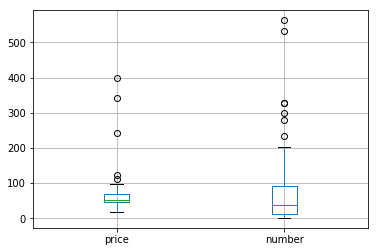

In [36]:
df2.boxplot(column=['price','number'])

And then we will represent a scatter facing these features to visually check if there is any pattern.

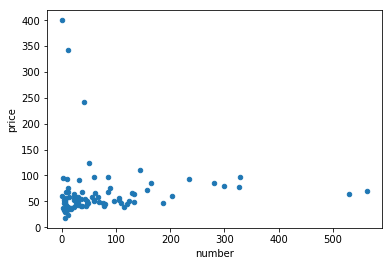

In [37]:
df2.plot.scatter(x='number', y='price')

Most of the points congregate in the same group, but as seen in the boxplot, separate outliers appear from the group.

The following are the most expensive neighborhoods.

In [38]:
df2.sort_values(by='price', ascending=False)[['Neighborhood', 'price']].head()

,Neighborhood,price
14,CARPESA,400.00000
34,FAITANAR,342.50000
81,SOTERNES,241.34146
31,ELS ORRIOLS,124.36000
55,LA XEREA,111.17931


The most economical neighborhoods.

In [39]:
df2.sort_values(by='price', ascending=True)[['Neighborhood', 'price']].head()

,Neighborhood,price
15,CASTELLAR-L'OLIVERAL,18.00000
46,LA LLUM,24.08333
56,LES CASES DE BARCENA,29.00000
21,EL CALVARI,32.16667
23,EL FORN D'ALCEDO,32.33333


Continuing with the exploratory analysis we obtain the correlation between all the variables involved. As there is one feature for each type of venue, it is difficult to represent them all at once.

In [40]:
fixed_columns.remove('Neighborhood')
columns = fixed_columns

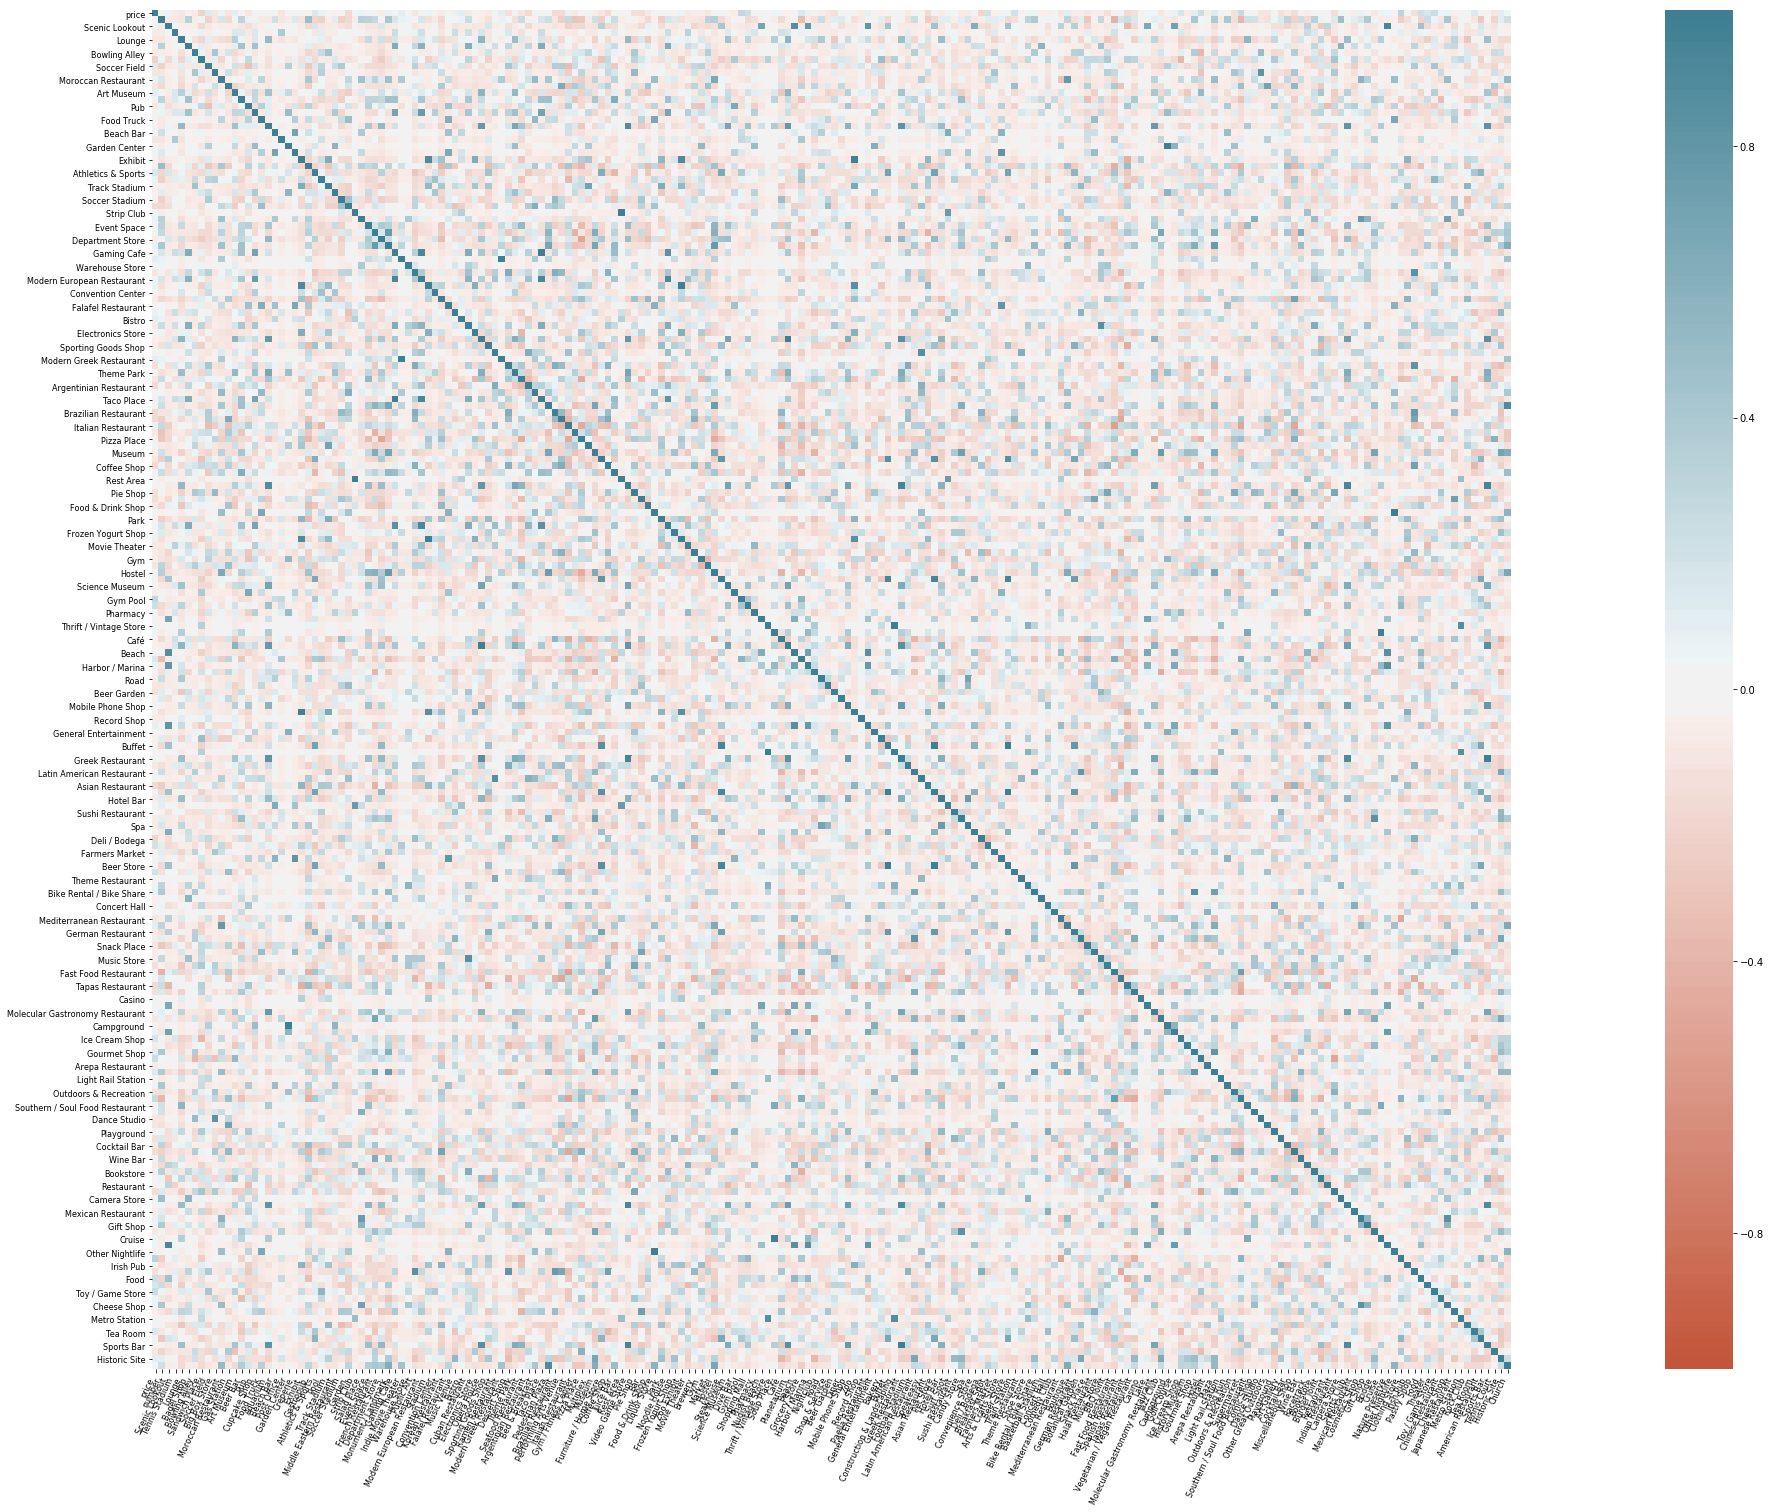

In [41]:

data = df2[['price', 'number'] + columns].astype({'number':'float'})
corr = data.corr()
plt.figure(figsize=(55,25))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    size=8
);
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=65,
    horizontalalignment='right',
    size=8
);

Selecting a column we can see which are the features with the highest correlation.  
In the following tables we observe the features with the highest correlation in price and number of rental properties.

In [42]:
venues_most_relevant_number = corr.sort_values(by='number', ascending=False).head(10)['number'].index.to_list()
venues_most_relevant_number.remove('number')
print(venues_most_relevant_number)
corr.sort_values(by='number', ascending=False).head(10)['number']


['Gastropub', 'Camera Store', 'Cheese Shop', 'Monument / Landmark', 'Gourmet Shop', 'Dog Run', 'Bike Rental / Bike Share', 'Plaza', 'Gift Shop']


number                     1.00000
Gastropub                  0.49969
Camera Store               0.47490
Cheese Shop                0.41811
Monument / Landmark        0.41089
Gourmet Shop               0.40389
Dog Run                    0.40192
Bike Rental / Bike Share   0.38243
Plaza                      0.37725
Gift Shop                  0.37633
Name: number, dtype: float64

In [43]:
venues_most_relevant_price = corr.sort_values(by='price', ascending=False).head(10)['price'].index.to_list()
venues_most_relevant_price.remove('price')
print(venues_most_relevant_price)
corr.sort_values(by='price', ascending=False).head(10)['price']

['Clothing Store', 'Gym Pool', 'Supermarket', 'Toy / Game Store', 'Hotel', 'Shopping Mall', 'Food', 'Breakfast Spot', 'Train Station']


price              1.00000
Clothing Store     0.31273
Gym Pool           0.28880
Supermarket        0.25571
Toy / Game Store   0.24057
Hotel              0.22697
Shopping Mall      0.22180
Food               0.22096
Breakfast Spot     0.19167
Train Station      0.18918
Name: price, dtype: float64


In order to graphically represent so many features against the dependent variables, it is necessary to apply a dimensionality reduction. We achieved this with the PCA, highlighting that it is recommended to standardize the variables before applying the PCA.

In [44]:
pca = PCA(n_components=2)
scl = StandardScaler()
data_scl = scl.fit_transform(df2[columns])
# principalComponents = pca.fit_transform(df2[columns])
principalComponents = pca.fit_transform(data_scl)

In [45]:
principalComponents[:,1]

array([ 1.69606563e-01,  3.02689671e-01, -2.04994232e-01,  1.79628435e-01,
       -2.29080113e+00,  1.44226453e+00, -2.98391969e+00, -2.91471774e-02,
       -2.79600276e+00, -1.27049214e-01,  8.24736728e-01,  1.38578509e-01,
       -4.44803928e+00,  3.17339457e+00, -1.75141930e+00, -6.47551962e+00,
       -2.14831337e+00, -2.13260950e+00, -1.43730661e+00,  2.14493261e+00,
        6.13994215e+00,  2.54812602e+00,  8.89224047e+00, -6.64926244e+00,
       -1.48724798e+00,  8.04689946e+00, -6.47255647e+00, -4.88040834e+00,
        6.94706994e+00,  4.58902100e+00, -6.79600203e+00,  7.85055969e-01,
       -4.06589217e-01,  6.15617942e+00, -3.52652935e+00, -2.26262715e+00,
        4.60505378e+00,  5.60854462e-01, -3.21083845e+00,  9.57752304e-01,
       -7.44698517e-01, -2.80057258e+00, -1.08910954e+00, -1.45859585e+00,
       -2.29908249e+00,  2.21333467e+00, -2.03253302e+00,  2.96106139e-01,
        2.33168415e+00, -3.52871971e+00, -1.28732887e+00,  1.07132991e+00,
        9.87813133e+00, -

Often we apply scatter where we appreciate a certain linear pattern.

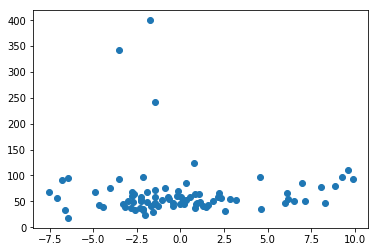

In [46]:
plt.scatter(x=principalComponents[:,1].squeeze(), y=data.price)

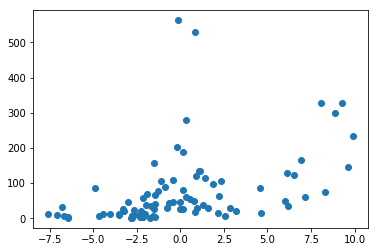

In [47]:
plt.scatter(x=principalComponents[:,1].squeeze(), y=data.number)

To check it we will apply machine learning, a linear regression and then we will obtain the R2 score. Remember that the closer to 1 the better the result.

In [48]:
X = principalComponents[:,1].reshape(-1, 1)
y = data['price'].values

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
regr = linear_model.LinearRegression()
regr.fit (X_train, y_train)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [-0.54974129]
Intercept:  68.96491296844616


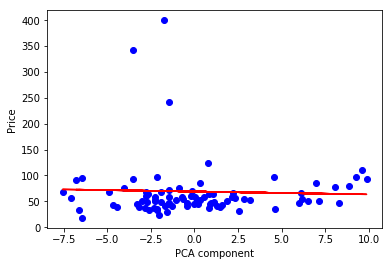

In [50]:
plt.scatter(X, y,  color='blue')
plt.plot(X_train, regr.coef_[0]*X_train + regr.intercept_, '-r')
plt.xlabel("PCA component");
plt.ylabel("Price");

In [51]:
regr.coef_[0]

-0.5497412906405663

In [52]:
y_test_hat = regr.predict(X_test)

print("Mean absolute error: %.2f" % np.mean(np.absolute(y_test_hat - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_test_hat - y_test) ** 2))
print("R2-score: %.2f" % r2_score(y_test_hat , y_test) )

Mean absolute error: 20.74
Residual sum of squares (MSE): 500.58
R2-score: -73.65


The obtained value discards the idea of ​​linear pattern, but we are going to check the other dependent variable.

In [61]:
X = principalComponents[:,1].reshape(-1, 1)
y = data['number'].values

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

regr = linear_model.LinearRegression()
regr.fit (X_train, y_train)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [9.85430093]
Intercept:  74.02762271659726


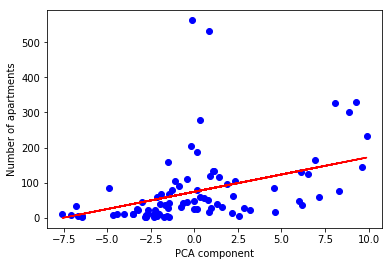

In [63]:
plt.scatter(X, y,  color='blue')
plt.plot(X_train, regr.coef_[0]*X_train + regr.intercept_, '-r')
plt.xlabel("PCA component");
plt.ylabel("Number of apartments");

In [56]:
y_test_hat = regr.predict(X_test)

print("Mean absolute error: %.2f" % np.mean(np.absolute(y_test_hat - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_test_hat - y_test) ** 2))
print("R2-score: %.2f" % r2_score(y_test_hat , y_test) )

Mean absolute error: 46.48
Residual sum of squares (MSE): 4410.52
R2-score: -1.05


In both cases, no pattern is found. But we will insist a little more.  
It is typical to reduce the dimensionality focusing only on the features with the best behavior, 
in this case we will focus on the types of venues that offer the best correlation coefficient.  
To keep as much information as possible we will work without applying PCA (although if we select all the components there is no loss of information), but we will apply standardization equally.
To achieve this we will apply multi linear regression.

In [57]:
scl = StandardScaler()
data_scl = scl.fit_transform(df2[venues_most_relevant_number])
X = data_scl
y = data['number'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

regr_n = linear_model.LinearRegression()
regr_n.fit (X_train, y_train)

y_test_hat = regr_n.predict(X_test)

print("Mean absolute error: %.2f" % np.mean(np.absolute(y_test_hat - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_test_hat - y_test) ** 2))
print("R2-score: %.2f" % r2_score(y_test_hat , y_test) )

Mean absolute error: 34.41
Residual sum of squares (MSE): 2016.86
R2-score: 0.78


In [58]:
scl = StandardScaler()
data_scl = scl.fit_transform(df2[venues_most_relevant_price])
X = data_scl
y = data['price'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

regr_p = linear_model.LinearRegression()
regr_p.fit (X_train, y_train)

y_test_hat = regr_p.predict(X_test)

print("Mean absolute error: %.2f" % np.mean(np.absolute(y_test_hat - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((y_test_hat - y_test) ** 2))
print("R2-score: %.2f" % r2_score(y_test_hat , y_test) )

Mean absolute error: 37.95
Residual sum of squares (MSE): 2117.09
R2-score: -1.29


To end this section we will calculate the error at each point to calculate which is the most advisable neighborhood where to put an apartment for rent.

In [59]:
scl = StandardScaler()
data_scl = scl.fit_transform(df2[venues_most_relevant_number])
X = data_scl
y = data['number'].values
y_test_hat = regr_n.predict(X)
error = y_test_hat - y
ind_best_neighborhood = np.argmax(error)
print(f'the best neighborhood is: {df2.iloc[ind_best_neighborhood, 0]}')

the best neighborhood is: L'ILLA PERDUDA


## Results and Discussion <a name="results"></a>

This project has shown that tourist rental apartments are not distributed equally among the different neighborhoods, the same happens with the price of such rentals.

With the data we obtain we can answer the questions posed at the beginning of the project.
By calculating the number of venues per neighborhood we have obtained that the neighborhood with the best price / number of venues ratio is Russafa.  
In the calculation of this coefficient we have found the limit of the maximum number of venues returned per request. The way in which we have solved the problem is by taking a smaller radius.

With the correlation between variables it has served to demonstrate that there is no type of venue that has a high correlation on its own.   
But with the application of linear regression, on the features with the highest correlation, it has been determined that the number of apartments for rent has an R2 score of 0.78 and the R2 score of the regression applied to the price has an R2 score of 0 (less than zero for computer effects).   
With this, two more questions are answered, only the number of houses for rent is related to the type and number of venues in the neighborhood.

Regarding the last question, the neighborhood that offers the most opportunities is L'illa perduda, it is the neighborhood that offers the least number of rental properties than the linear regression proposes.

## Conclusion <a name="conclusion"></a>

To answer the questions asked at the beginning, information was collected from various sources, data exploration procedures, selection of features by correlation and linear regression analysis were applied to reach the conclusion that only the number of rental homes has a relevant relationship with the type and number of venues in the neighborhood.
Finally, with the information contained in this project, clients could reconsider the choice of destination, and the owners could see which neighborhoods are saturated.